In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Helper Functions for ARIMA/SARIMA Time Series Models

### This function fits a SARIMA model on the provided training data, evaluates the model performance, and plots diagnostic results. The function uses the specified pdq (ARIMA) and pdqs (seasonal ARIMA) parameters to define the SARIMA model and trains it on the training portion of the data.

In [2]:
def fit_model(df, pdq, pdqs):
    # split the data into train and test sets using the train_test function
    train, test = train_test(df)
    
    # initialize the SARIMA model with the specified order and seasonal_order
    model = SARIMAX(train, order=pdq, seasonal_order=pdqs)
    
    # fit the model to the training data and generate the results
    results = model.fit()
    
    # access and display the residuals of the model
    residuals = results.resid
    
    # print the summary of the fitted SARIMA model
    print(results.summary())
    
    # plot model diagnostics to check for issues like autocorrelation or heteroscedasticity
    results.plot_diagnostics(figsize=(11, 8))
    plt.show()
    
    # return the train, test datasets and the fitted model results
    return train, test, results

### This helper function splits the input time series DataFrame into training and testing datasets based on the year 2000. It returns the data prior to 2000 as the training set and the data from 2000 onwards as the test set.

In [3]:
def train_test(df):
    # select data before the year 2000 as the training set
    train = df[:'2000']
    
    # select data starting from the year 2000 as the test set
    test = df['2000':]
    
    # return the training and test sets
    return train, test

### This function calculates the Root Mean Square Error (RMSE) for the last 40 observations of the training set by comparing the actual values to the model predictions. It optionally displays a plot comparing the actual vs predicted values.

In [4]:
def train_RMSE(train, results, display=True):
    # generate model predictions for the last 40 observations of the training set
    train_pred = results.predict(-40)
    
    # calculate the RMSE between the actual training data and the predicted data
    rmse = sqrt(MSE(train[-40:], train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    
    # if display is set to True, generate a plot of actual vs predicted values
    if display:
        plt.figure(figsize=(15, 7))
        
        # plot the actual training data for the last 60 observations
        train[-60:].plot(label='Actual', color='b')
        
        # plot the predicted values from the model
        train_pred.plot(label='Predicted', color='r')
        
        # add a legend and title to the plot
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Prevalence')
        
        # show the plot
        plt.show()

### This function calculates the RMSE for the model on the test data. It iterates through the test set, making out-of-sample forecasts and compares the predictions to the actual values. The RMSE is computed, and optionally, a plot of actual vs predicted values is displayed.

In [5]:
def test_RMSE(df, pdq, pdqs, display=True):
    # convert the DataFrame to numpy values for train/test split
    X = df.values
    
    # split the data into training and test sets (use the last 40 points for test)
    train, test = X[:-40], X[-40:]
    
    # initialize the history list with training data
    history = [x for x in train]
    
    # initialize an empty list to store the predictions
    predictions = []
    
    # loop through the test data, fitting the model at each step and making predictions
    for t in range(len(test)):
        # fit SARIMA model on the available history data
        model = SARIMAX(history, order=pdq, seasonal_order=pdqs)
        fit_model = model.fit(disp=0)
        
        # make a one-step forecast for the next point in the test set
        output = fit_model.forecast()
        yhat = output[0]
        
        # append the forecasted value to predictions
        predictions.append(yhat)
        
        # update history with the actual test data point to simulate rolling forecast
        history.append(test[t])
    
    # calculate the RMSE between the test data and the predictions
    rmse = sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    
    # if display is set to True, generate a plot of actual vs predicted values
    if display:
        plt.figure(figsize=(13, 6))
        
        # plot actual test data
        plt.plot(history[-40:], label='Actual', color='b')
        
        # plot predicted values
        plt.plot(predictions, label='Predictions', color='r')
        
        # add a title and legend to the plot
        plt.title('Actual Test Data vs. Predictions')
        plt.legend(loc='best')
        
        # show the plot
        plt.show()

### This function fits a SARIMA model on the entire dataset and generates a forecast for the future (in this case, from 2020 to 2025). It also calculates and displays the confidence intervals for the forecasted values.

In [6]:
def forecast_model(df, pdq, pdqs, display=True):
    # initialize and fit the SARIMA model on the full dataset
    model = SARIMAX(df, order=pdq, seasonal_order=pdqs)
    fit_model = model.fit()
    
    # generate dynamic predictions for the years 2020 to 2030
    output = fit_model.get_prediction(start='2020', end='2030', dynamic=True)
    
    # extract confidence intervals for the forecast
    forecast_ci = output.conf_int()
    
    # if display is set to True, plot the forecast along with confidence intervals
    if display:
        fig, ax = plt.subplots(figsize=(13, 6))
        
        # plot the forecasted values
        output.predicted_mean.plot(label='Forecast')
        
        # plot the confidence intervals
        ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                        color='k', alpha=.25, label='Conf Interval')
        
        # add a title and legend to the plot
        plt.title('Forecast of Prevalence')
        plt.xlabel('Time')
        plt.legend(loc='best')
        
        # show the plot
        plt.show()
    
    # calculate the cumulative forecast values for 1, 3, and 5 years
    year_1 = (1 + output.predicted_mean[:2]).prod()
    year_3 = (1 + output.predicted_mean[:4]).prod()
    year_5 = (1 + output.predicted_mean[:6]).prod()
    year_7 = (1 + output.predicted_mean[:8]).prod()
    year_9 = (1+ output.predicted_mean[:10]).prod()
    
    # print the expected increase in prevalence over 1, 3, and 5 years
    print(f'Total expected increase in prevalence in 1 year: {year_1}%')
    print(f'Total expected increase in prevalence in 3 years: {year_3}%')
    print(f'Total expected increase in prevalence in 5 year: {year_5}%')
    print(f'Total expected increase in prevalence in 7 year: {year_7}%')
    print(f'Total expected increase in prevalence in 9 year: {year_9}%')

    # return a list of the cumulative forecast values
    tot_prev = [year_1, year_3, year_5, year_7,year_9]
    return tot_prev

In [7]:
# import dataframe from data-analysis folder that has the label_encoded genres and year feature
df = pd.read_csv(r'/Users/adityamxr/Desktop/spotify-time-series/data-analysis/label_encoded_streams_df.csv')

In [8]:
# verify import
df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,cleaned_broad_genre,labelenc_genre
0,0.995,0.708,158648,0.1950,0,0.563,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928,unknown,500
1,0.994,0.379,282133,0.0135,0,0.901,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928,early music,138
2,0.604,0.749,104300,0.2200,0,0.000,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928,epicore,149
3,0.995,0.781,180760,0.1300,0,0.887,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928,tango,477
4,0.990,0.210,687733,0.2040,0,0.908,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928,classical,96


#### Remove cleaned_broad_genre, and all features except the top 4 features: Explicit, Acousticness, Loudness, Labelenc_genre

In [9]:
features_to_remove = ['danceability', 'duration_ms','energy', 'instrumentalness', 'liveness', 'mode','speechiness','tempo','valence','cleaned_broad_genre','popularity']

df = df.drop(columns=features_to_remove)

In [10]:
df.head()

,acousticness,explicit,loudness,year,labelenc_genre
0,0.995,0,-12.428,1928,500
1,0.994,0,-28.454,1928,138
2,0.604,0,-19.924,1928,149
3,0.995,0,-14.734,1928,477
4,0.990,0,-16.829,1928,96


### Dataframe of Annual Averages of the Top 4 Features

In [11]:
# compute annual averages of the selected features
annual_avg_top_4 = df[["acousticness", "explicit", "loudness", "labelenc_genre", "year"]] \
    .groupby("year").mean() \
    .sort_values(by="year") \
    .reset_index()

# verify aggregation
annual_avg_top_4.head()

,year,acousticness,explicit,loudness,labelenc_genre
0,1921,0.895823,0.054688,-17.095437,342.226562
1,1922,0.939236,0.000000,-19.179958,418.625000
2,1923,0.976329,0.000000,-14.373882,304.301775
3,1924,0.935575,0.000000,-14.202304,350.063291
4,1925,0.965422,0.000000,-14.516707,354.342205


#### Plot the line graphs of each feature with year as the modularity

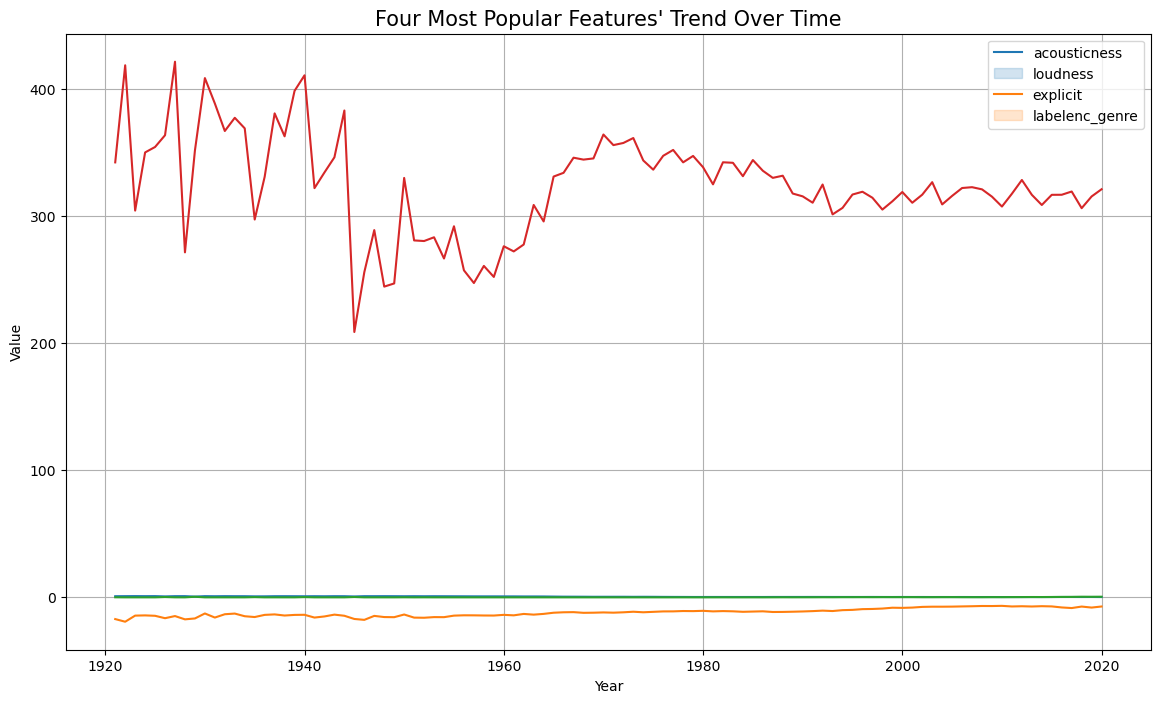

In [12]:
# create a simple line plot for initial analysis
plt.figure(figsize=(14,8))
plt.title("Four Most Popular Features' Trend Over Time", fontdict={"fontsize": 15})

# list of the four features you want to plot
features = ["acousticness", "loudness", "explicit", "labelenc_genre"]

# plot each feature as a line in the same plot
for feature in features:
    sns.lineplot(x='year', y=feature, data=annual_avg_top_4, label=feature)

# add labels and legend
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend(features)
plt.grid(True)
plt.show()

### Clearly normalization of the numeric features is required, but save the raw df for ARIMA/SARIMA since normalized features is only for the purpose of visualizing the trends/seasonalities in the data –– for ARIMA/SARIMA time series modeling, normalizing the features can cause a loss in the patterns

In [13]:
# create copy of original df
df2 = annual_avg_top_4.copy()
df2.head()

,year,acousticness,explicit,loudness,labelenc_genre
0,1921,0.895823,0.054688,-17.095437,342.226562
1,1922,0.939236,0.000000,-19.179958,418.625000
2,1923,0.976329,0.000000,-14.373882,304.301775
3,1924,0.935575,0.000000,-14.202304,350.063291
4,1925,0.965422,0.000000,-14.516707,354.342205


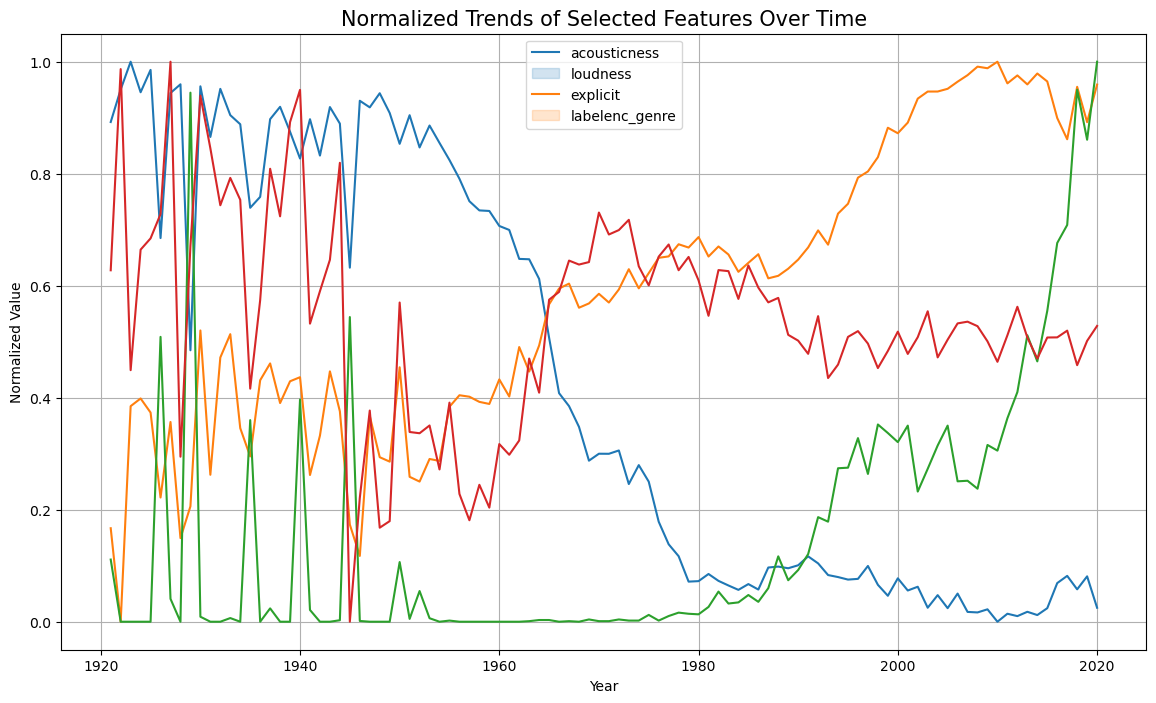

In [14]:
# create a MinMaxScaler instance to scale features between 0 and 1
scaler = MinMaxScaler()

# list of the features to scale
features = ["acousticness", "loudness", "explicit", "labelenc_genre"]

# scale the selected features
df2[features] = scaler.fit_transform(df2[features])

# create a line plot again with normalized features
plt.figure(figsize=(14,8))
plt.title("Normalized Trends of Selected Features Over Time", fontdict={"fontsize": 15})

# plot each feature
for feature in features:
    sns.lineplot(x='year', y=feature, data=df2, label=feature)

# add labels and legend
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend(df2[features])
plt.grid(True)
plt.show()

### Normalization went smoothly, but the legend doesn't align with the line plots

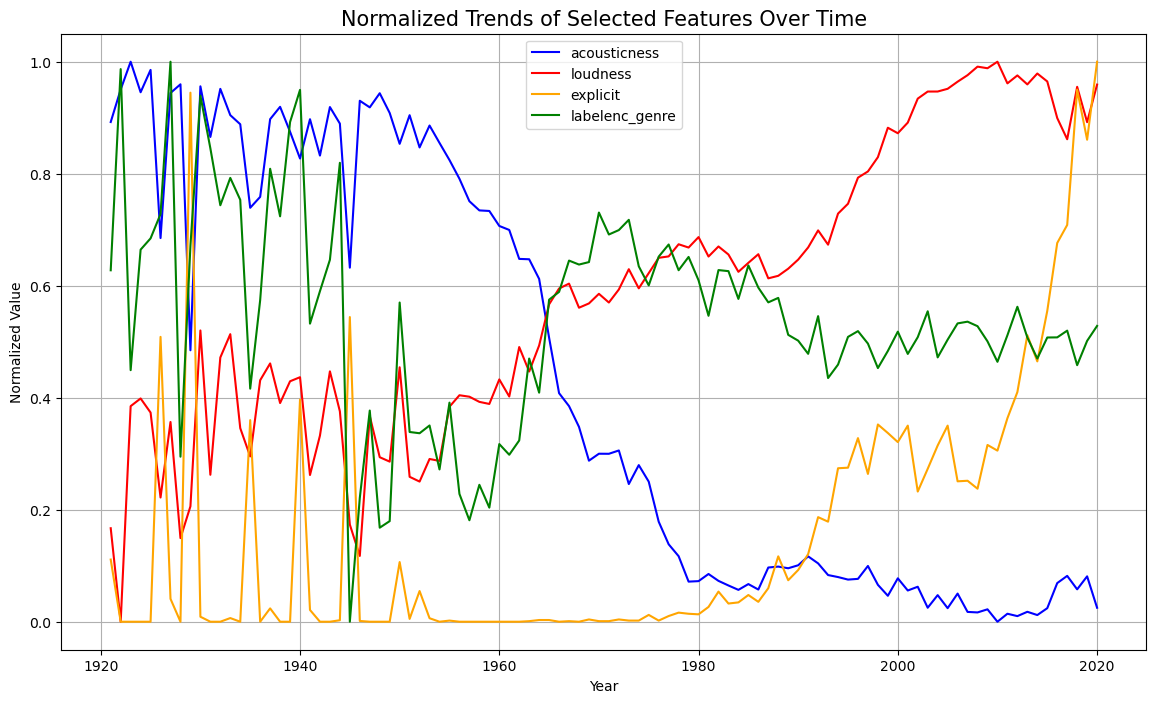

In [15]:
# create a simple line plot for initial analysis
plt.figure(figsize=(14,8))
plt.title("Normalized Trends of Selected Features Over Time", fontdict={"fontsize": 15})

# plot each feature separately
sns.lineplot(x='year', y="acousticness", data=df2, label="acousticness", color="blue")
sns.lineplot(x='year', y="loudness", data=df2, label="loudness", color="red")
sns.lineplot(x='year', y="explicit", data=df2, label="explicit", color="orange")
sns.lineplot(x='year', y="labelenc_genre", data=df2, label="labelenc_genre", color="green")

# add labels and legend
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend(loc="best")
plt.grid(True)
plt.show()

### Normalization with aligned legend went smoothly

In [16]:
df2.head()

,year,acousticness,explicit,loudness,labelenc_genre
0,1921,0.892317,0.111019,0.166953,0.627567
1,1922,0.950385,0.000000,0.000000,0.986835
2,1923,1.000000,0.000000,0.384927,0.449223
3,1924,0.945488,0.000000,0.398669,0.664419
4,1925,0.985411,0.000000,0.373488,0.684541


In [17]:
# ensure index is appropriate
df2.index

RangeIndex(start=0, stop=100, step=1)

In [18]:
df2.year=pd.to_datetime(df2.year, format='%Y')

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            100 non-null    datetime64[ns]
 1   acousticness    100 non-null    float64       
 2   explicit        100 non-null    float64       
 3   loudness        100 non-null    float64       
 4   labelenc_genre  100 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.0 KB


In [20]:
df2.set_index('year', inplace=True)
df2.head()

,acousticness,explicit,loudness,labelenc_genre
year,,,,
1921-01-01,0.892317,0.111019,0.166953,0.627567
1922-01-01,0.950385,0.000000,0.000000,0.986835
1923-01-01,1.000000,0.000000,0.384927,0.449223
1924-01-01,0.945488,0.000000,0.398669,0.664419
1925-01-01,0.985411,0.000000,0.373488,0.684541


In [21]:
# create separate dataframes for each individual feature with year as the index

acousticness_df = df2[['acousticness']].copy()
explicit_df = df2[['explicit']].copy()
loudness_df = df2[['loudness']].copy()
labelenc_genre_df = df2[['labelenc_genre']].copy()

# verify 
print(acousticness_df.head())
print(explicit_df.head())
print(loudness_df.head())
print(labelenc_genre_df.head())

            acousticness
year                    
1921-01-01      0.892317
1922-01-01      0.950385
1923-01-01      1.000000
1924-01-01      0.945488
1925-01-01      0.985411
            explicit
year                
1921-01-01  0.111019
1922-01-01  0.000000
1923-01-01  0.000000
1924-01-01  0.000000
1925-01-01  0.000000
            loudness
year                
1921-01-01  0.166953
1922-01-01  0.000000
1923-01-01  0.384927
1924-01-01  0.398669
1925-01-01  0.373488
            labelenc_genre
year                      
1921-01-01        0.627567
1922-01-01        0.986835
1923-01-01        0.449223
1924-01-01        0.664419
1925-01-01        0.684541


### Ensure index is sorted

In [22]:
acousticness_df.sort_index(inplace=True)
explicit_df.sort_index(inplace=True)
loudness_df.sort_index(inplace=True)
labelenc_genre_df.sort_index(inplace=True)

# verify sorting
print(acousticness_df.head())
print(explicit_df.head())
print(loudness_df.head())
print(labelenc_genre_df.head())

            acousticness
year                    
1921-01-01      0.892317
1922-01-01      0.950385
1923-01-01      1.000000
1924-01-01      0.945488
1925-01-01      0.985411
            explicit
year                
1921-01-01  0.111019
1922-01-01  0.000000
1923-01-01  0.000000
1924-01-01  0.000000
1925-01-01  0.000000
            loudness
year                
1921-01-01  0.166953
1922-01-01  0.000000
1923-01-01  0.384927
1924-01-01  0.398669
1925-01-01  0.373488
            labelenc_genre
year                      
1921-01-01        0.627567
1922-01-01        0.986835
1923-01-01        0.449223
1924-01-01        0.664419
1925-01-01        0.684541


### Index is sorted now

### ARIMA/SARIMA for Acousticness (non-normalized)

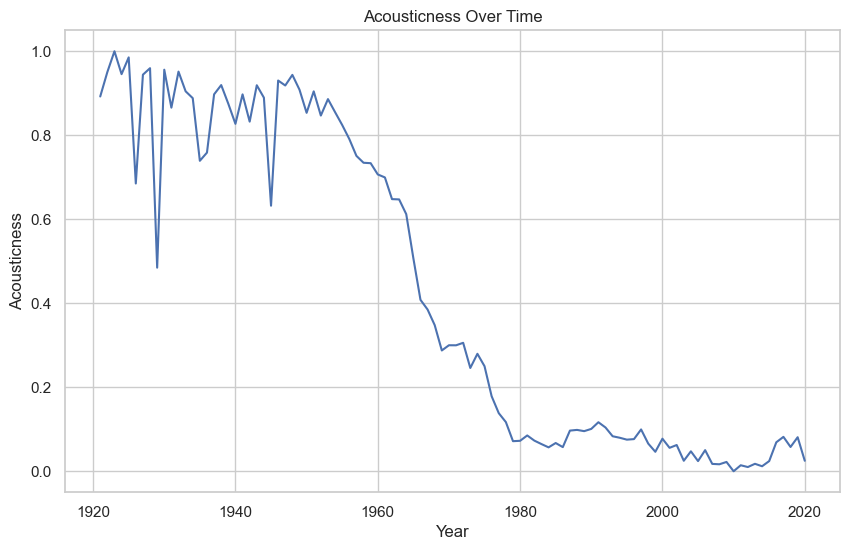

In [23]:
sns.set(style="whitegrid")

# plot line plot acousticness
plt.figure(figsize=(10, 6))
sns.lineplot(x=acousticness_df.index, y=acousticness_df['acousticness'])
plt.title('Acousticness Over Time')
plt.xlabel('Year')
plt.ylabel('Acousticness')
plt.show()

### Check for stationarity with ADF test: 

- Null hypothesis: 

    - acousticness time series is non-stationary (it has a unit root), meaning that different components of the 
      time series - trend, seasonality, and irregularity -- are present and change over time
      
- Alternative hypothesis:

    - acousticness time series is stationary (it does not have a unit root), meaning that it has a constant mean 
      and variance over time
      
- Decision Rule: 

    - If the p-value from the ADF test is greater than 0.05, we fail to reject the 
      null hypothesis (H₀). This implies the time series is non-stationary.
      
    - If the p-value is less than 0.05, we reject the null hypothesis and conclude that the time series is 
      stationary.


In [24]:
# perform Augmented Dickey-Fuller test to check for stationarity
result = adfuller(acousticness_df['acousticness'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print('We reject the null hypothesis and conclude that the time series is stationary.')
else:
    print('We fail to reject the null hypothesis and it is implied that the time series is non-stationary.')

ADF Statistic: -1.8087858426598487
p-value: 0.3761085733859244
We fail to reject the null hypothesis and it is implied that the time series is non-stationary.


In [25]:
acousticness_df.head()

,acousticness
year,
1921-01-01,0.892317
1922-01-01,0.950385
1923-01-01,1.000000
1924-01-01,0.945488
1925-01-01,0.985411


## Get Rolling Mean and Rolling Std for Each Individual Feature

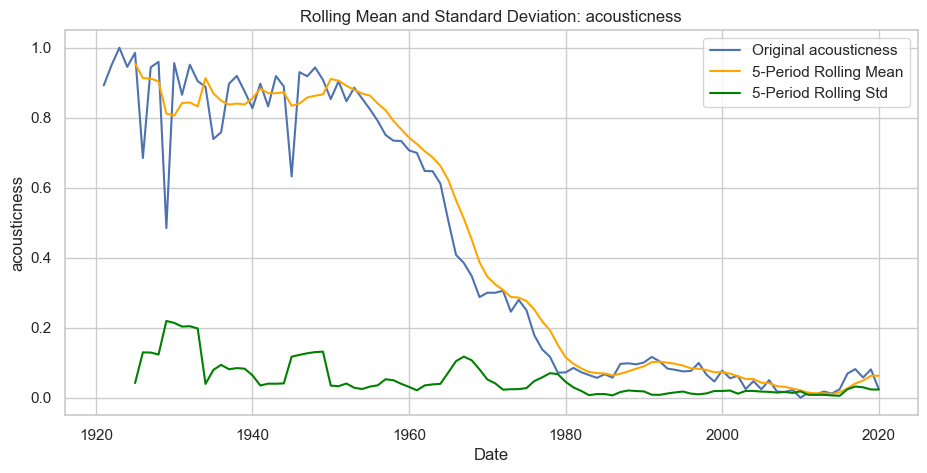

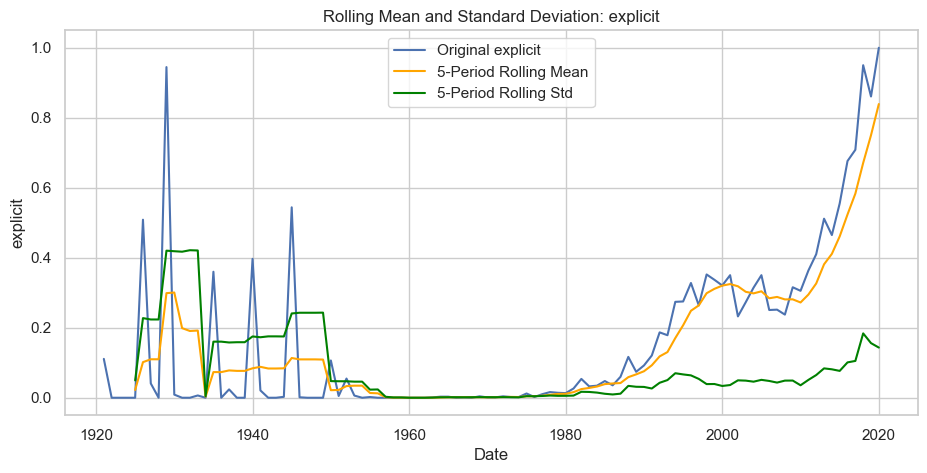

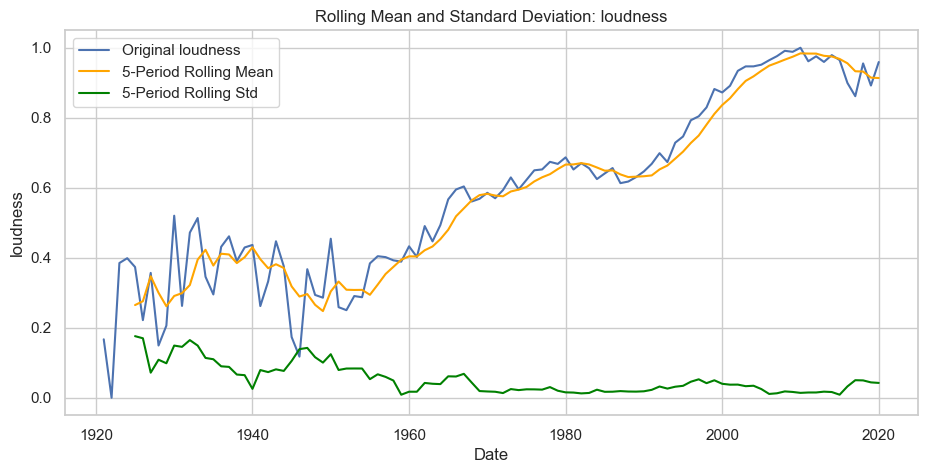

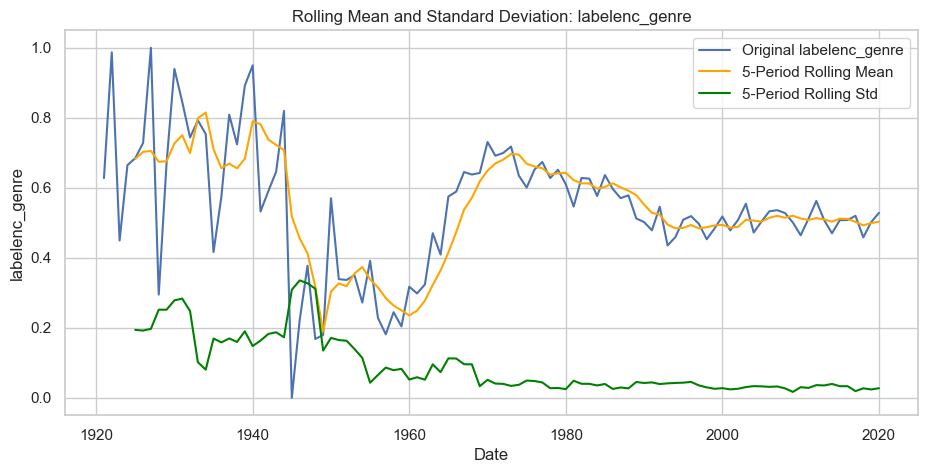

In [26]:
# define the window size for rolling calculations
window_size = 5

# loop through each column in df2 and plot rolling mean and std for each feature
for column in df2.columns:
    # Calculate rolling mean and std for the current feature
    rolling_mean = df2[column].rolling(window=window_size).mean()
    rolling_std = df2[column].rolling(window=window_size).std()

    # plot the original, rolling mean, and rolling std for each feature
    plt.figure(figsize=(11, 5))
    plt.plot(df2[column], label=f'Original {column}', color='b')
    plt.plot(rolling_mean, label=f'{window_size}-Period Rolling Mean', color='orange')
    plt.plot(rolling_std, label=f'{window_size}-Period Rolling Std', color='green')
    plt.title(f'Rolling Mean and Standard Deviation: {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend(loc='best')
    plt.show()

### Perform ARIMA/SARIMA for Acousticness

In [27]:
# use auto arima function to find the best non-seasonal and seasonal parameters to fit the model for acousticness
results = pm.auto_arima(acousticness_df,information_criterion='aic', seasonal_test = 'df',
                        start_p=1,start_q=1, max_p=4, max_q=4,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-209.705, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-177.473, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-202.141, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-209.978, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-178.665, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-210.633, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-207.772, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-209.859, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-211.315, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-210.164, Time=0.07 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-209.385, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-208.678, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-211.624, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-211.120, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.39718D-01    |proj g|=  6.24014D+00

At iterate    5    f= -9.81293D-01    |proj g|=  2.54261D-01

At iterate   10    f= -9.83587D-01    |proj g|=  1.74694D-02

At iterate   15    f= -9.83831D-01    |proj g|=  2.28101D-01

At iterate   20    f= -9.85344D-01    |proj g|=  2.55967D-02

At iterate   25    f= -9.85639D-01    |proj g|=  1.16376D-02

At iterate   30    f= -9.86902D-01    |proj g|=  5.73932D-02

At iterate   35    f= -9.87584D-01    |proj g|=  9.05911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

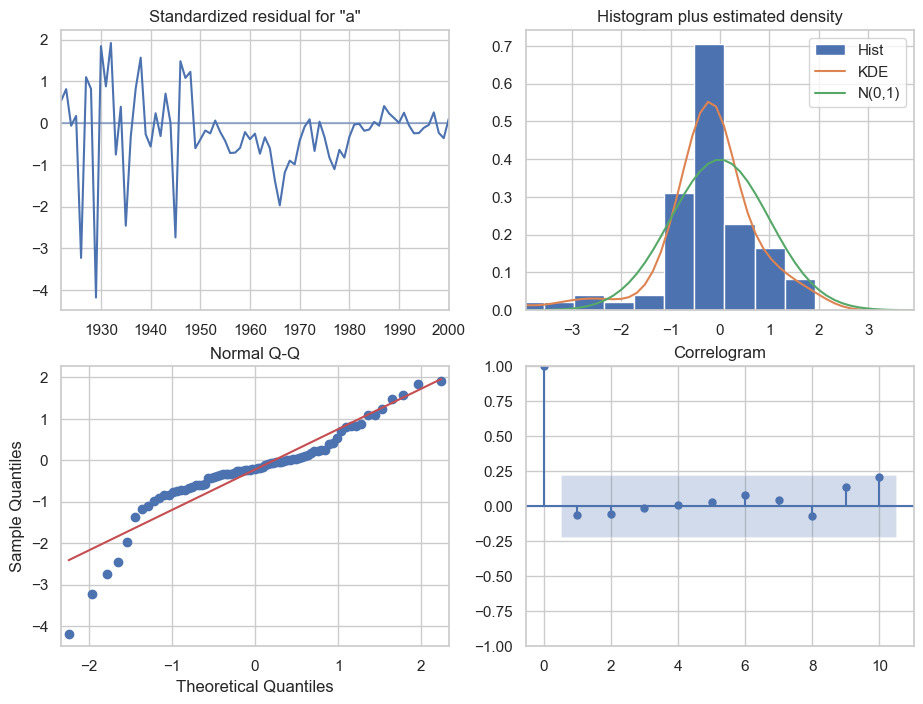

In [28]:
# fit the SARIMA model and get results
pdq = (2,1,2)
pdqs = (0,0,0,0)
train, test, results = fit_model(acousticness_df,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.05358


<Figure size 1500x700 with 0 Axes>

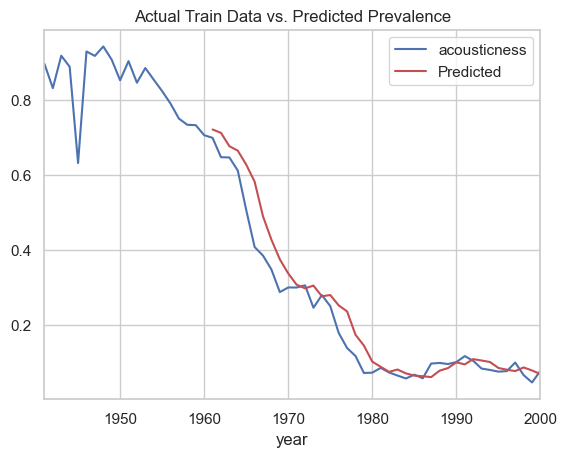

In [29]:
train_RMSE(train, results)

/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA model RMSE on test data: 0.02066


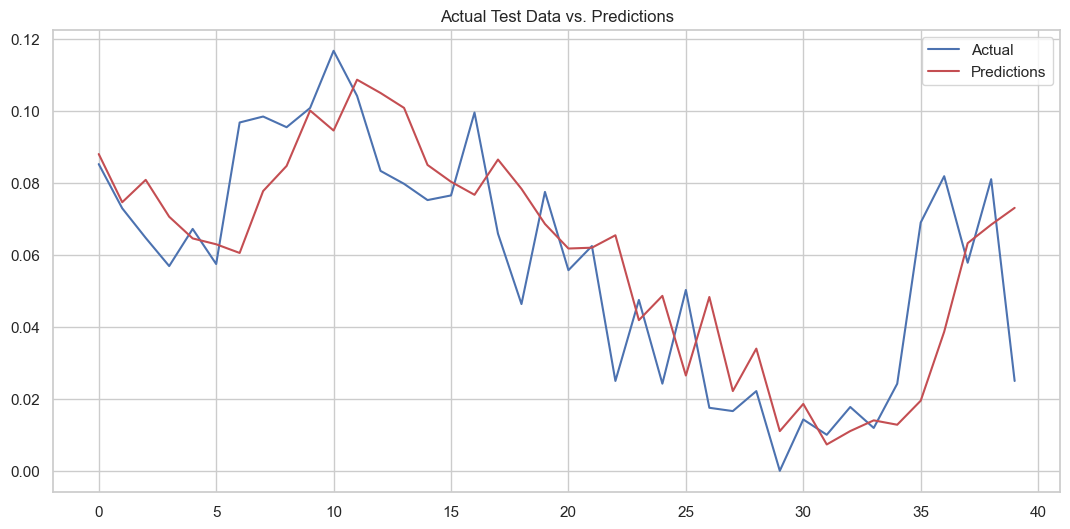

In [30]:
test_RMSE(acousticness_df,pdq=pdq,pdqs=pdqs, display=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04242D+00    |proj g|=  7.32687D+00

At iterate    5    f= -1.08767D+00    |proj g|=  2.71009D-01

At iterate   10    f= -1.08987D+00    |proj g|=  1.62299D-02

At iterate   15    f= -1.09007D+00    |proj g|=  2.31029D-01

At iterate   20    f= -1.09148D+00    |proj g|=  2.86828D-02

At iterate   25    f= -1.09181D+00    |proj g|=  4.05990D-02

At iterate   30    f= -1.09240D+00    |proj g|=  1.67830D-01

At iterate   35    f= -1.09377D+00    |proj g|=  3.18102D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


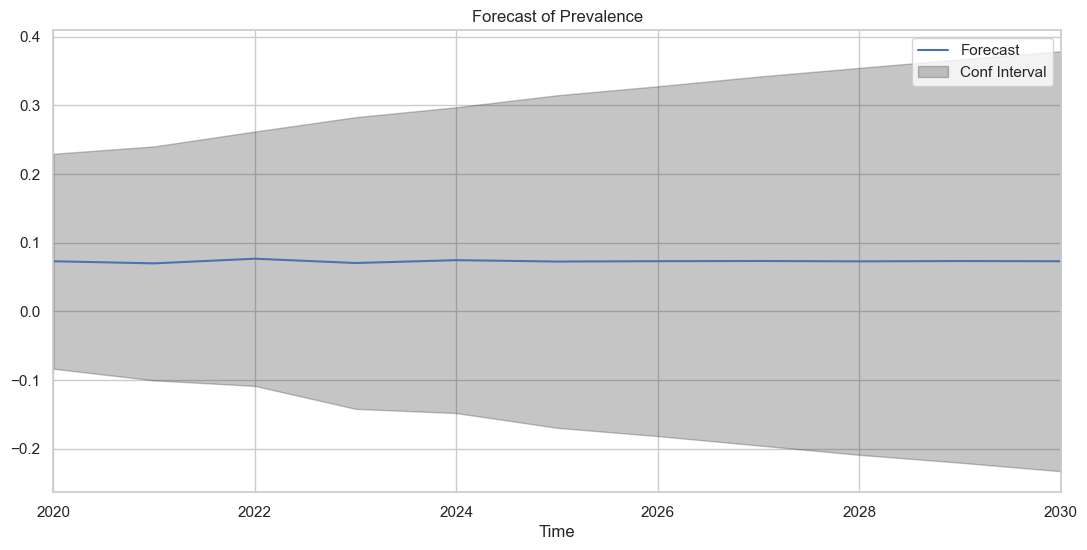

Total expected increase in prevalence in 1 year: 1.1481020833045437%
Total expected increase in prevalence in 3 years: 1.3232987044866378%
Total expected increase in prevalence in 5 year: 1.5252906325104623%
Total expected increase in prevalence in 7 year: 1.7569416097109436%
Total expected increase in prevalence in 9 year: 2.0232083654553974%


In [31]:
acous_prev=forecast_model(acousticness_df,pdq=pdq,pdqs=pdqs)

### Perform ARIMA/SARIMA for Explicit

In [32]:
# use auto arima function to find the best non-seasonal and seasonal parameters to fit the model for explicit feature
results = pm.auto_arima(explicit_df,information_criterion='aic', seasonal_test = 'df',
                        start_p=1,start_q=1, max_p=4, max_q=4,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-84.311, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-42.427, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.332, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-85.108, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.209, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-85.174, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-82.463, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-87.901, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-86.838, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-86.080, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-85.089, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-87.699, Time=0.01 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 0.408 seconds


ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True)

/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00768D-01    |proj g|=  1.12212D+01

At iterate    5    f= -4.12419D-01    |proj g|=  1.49308D-01

At iterate   10    f= -4.60525D-01    |proj g|=  4.70608D-02

At iterate   15    f= -4.65853D-01    |proj g|=  1.25296D-02

At iterate   20    f= -4.65915D-01    |proj g|=  2.72029D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   6.631D-06  -4.659D-01
  F = -0.46591512086167597     

CONVERG

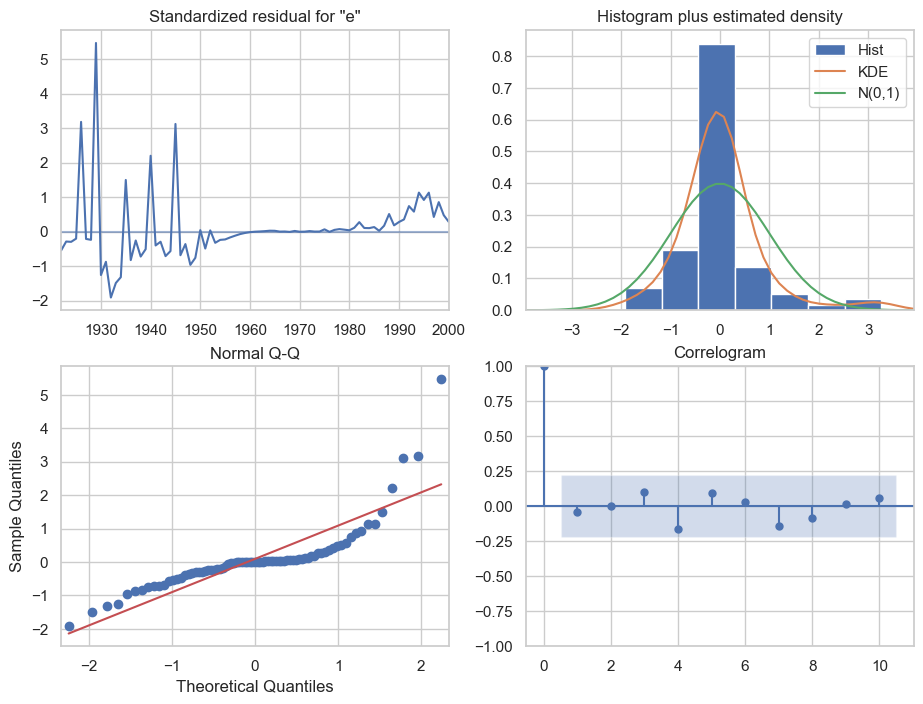

In [33]:
# fit the SARIMA model and get results
pdq = (0,1,3)
pdqs = (0,0,0,0)
train, test, results = fit_model(explicit_df,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.05890


<Figure size 1500x700 with 0 Axes>

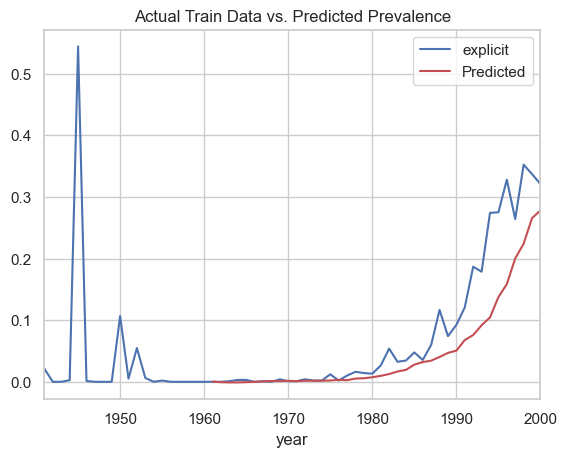

In [34]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.13249


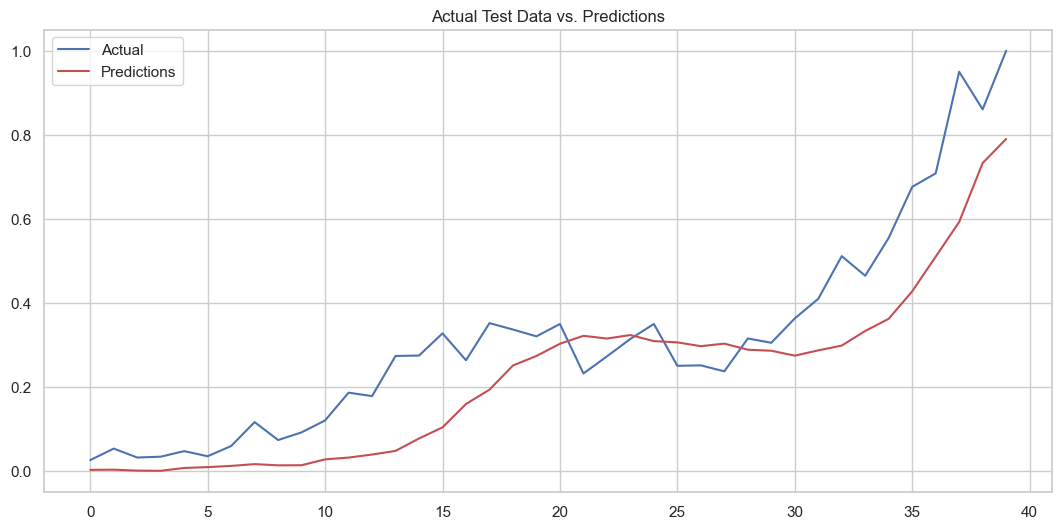

In [35]:
test_RMSE(explicit_df,pdq=pdq,pdqs=pdqs, display=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27565D-01    |proj g|=  9.78175D+00

At iterate    5    f= -4.17239D-01    |proj g|=  2.13931D-01

At iterate   10    f= -4.78250D-01    |proj g|=  1.62545D-02

At iterate   15    f= -4.78494D-01    |proj g|=  2.45912D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   2.459D-05  -4.785D-01
  F = -0.47849393110683830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


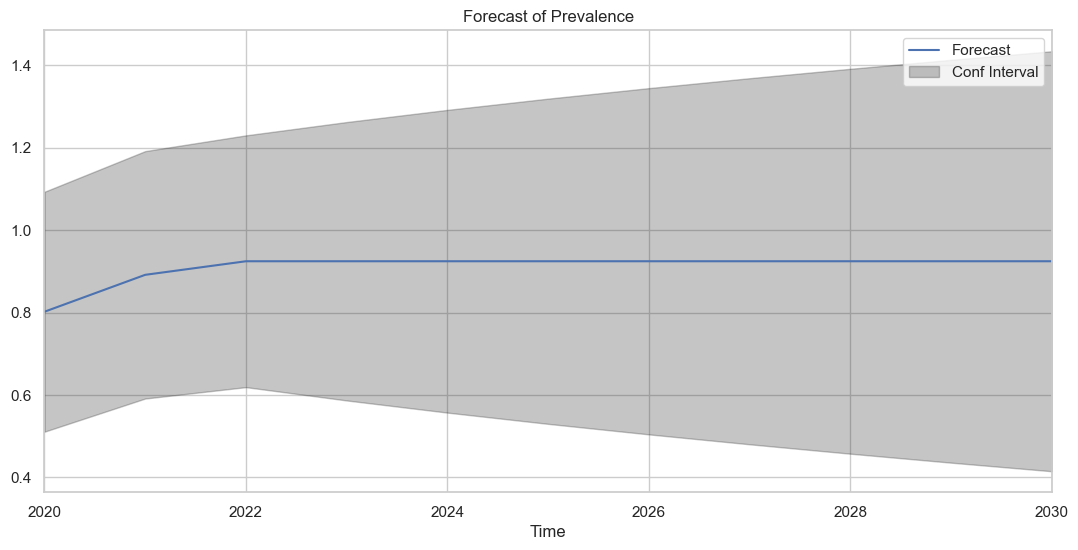

Total expected increase in prevalence in 1 year: 3.4084953663652198%
Total expected increase in prevalence in 3 years: 12.62371870235607%
Total expected increase in prevalence in 5 year: 46.753261115960456%
Total expected increase in prevalence in 7 year: 173.15558723351572%
Total expected increase in prevalence in 9 year: 641.2998082811431%


In [36]:
explicit_prev=forecast_model(explicit_df,pdq=pdq,pdqs=pdqs)

### Perform ARIMA/SARIMA for Loudness

In [38]:
# use auto arima function to find the best non-seasonal and seasonal parameters to fit the model for explicit feature
results = pm.auto_arima(loudness_df,information_criterion='aic', seasonal_test = 'df',
                        start_p=1,start_q=1, max_p=4, max_q=4,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-211.834, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-186.846, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-199.193, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-213.420, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-188.105, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-212.182, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-215.957, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-215.136, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-215.316, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-216.619, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-214.915, Time=0.06 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-212.619, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-214.567, Time=0.02 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 0.421 seconds


ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True)

/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.81401D-01    |proj g|=  1.56764D+01

At iterate    5    f= -9.69774D-01    |proj g|=  2.42183D+00

At iterate   10    f= -1.01641D+00    |proj g|=  5.54301D-02

At iterate   15    f= -1.02072D+00    |proj g|=  8.27683D-01

At iterate   20    f= -1.02663D+00    |proj g|=  1.23778D-02

At iterate   25    f= -1.02701D+00    |proj g|=  3.23462D-02
                               SARIMAX Results                                
Dep. Variable:               loudness   No. Observations:                   80
Model:               SARIMAX(0, 1, 3)   Log Likelihood                  82.177
Date:                Fri, 06 Sep 2024   AIC                           -156.353
Time:                        20:35:15   BIC                           -146.875
Sample:                    01-01-1921   HQIC                      

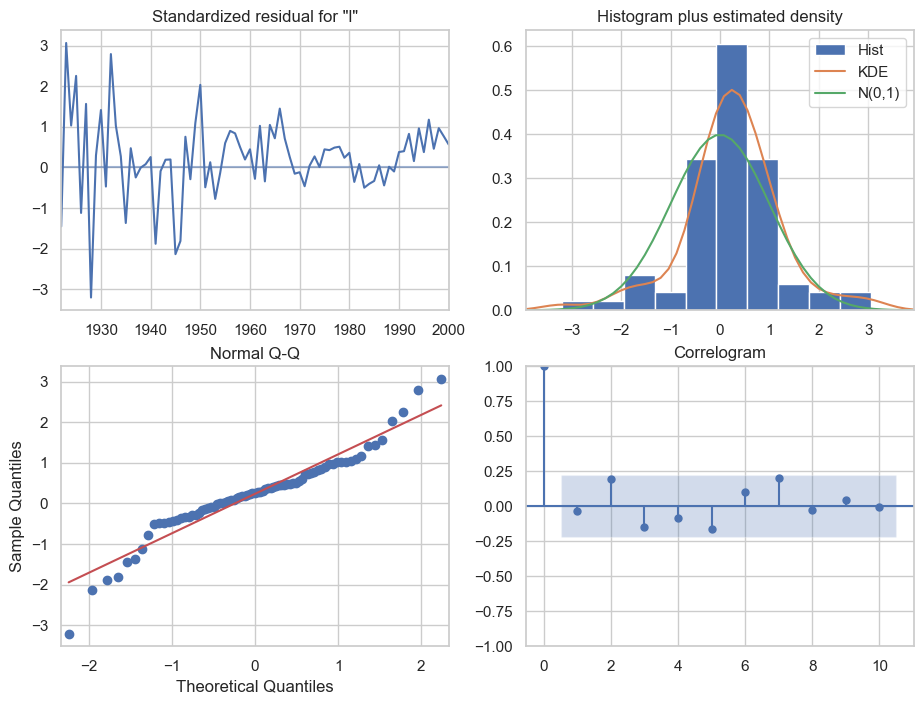

In [39]:
# fit the SARIMA model and get results
pdq = (0,1,3)
pdqs = (0,0,0,0)
train, test, results = fit_model(loudness_df,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.04879


<Figure size 1500x700 with 0 Axes>

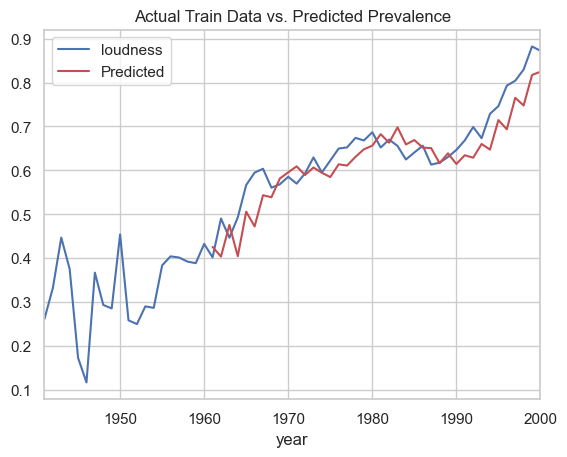

In [40]:
train_RMSE(train, results)

/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA model RMSE on test data: 0.04779


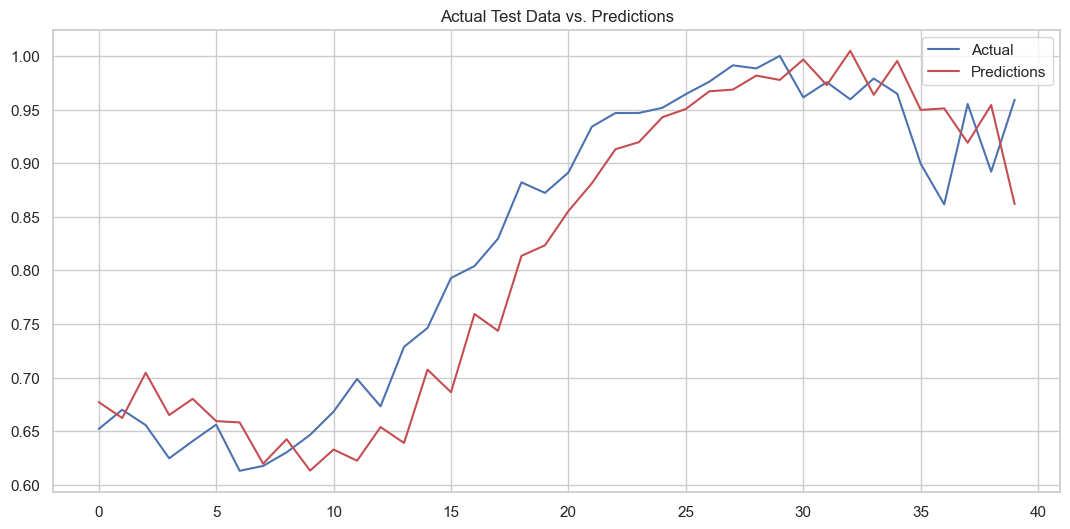

In [41]:
test_RMSE(loudness_df,pdq=pdq,pdqs=pdqs, display=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.91310D-01    |proj g|=  1.62316D+01

At iterate    5    f= -1.05393D+00    |proj g|=  1.97434D+00

At iterate   10    f= -1.10293D+00    |proj g|=  5.21228D-02

At iterate   15    f= -1.10550D+00    |proj g|=  7.86251D-01

At iterate   20    f= -1.11256D+00    |proj g|=  7.46617D-03

At iterate   25    f= -1.11284D+00    |proj g|=  1.39047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   

/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


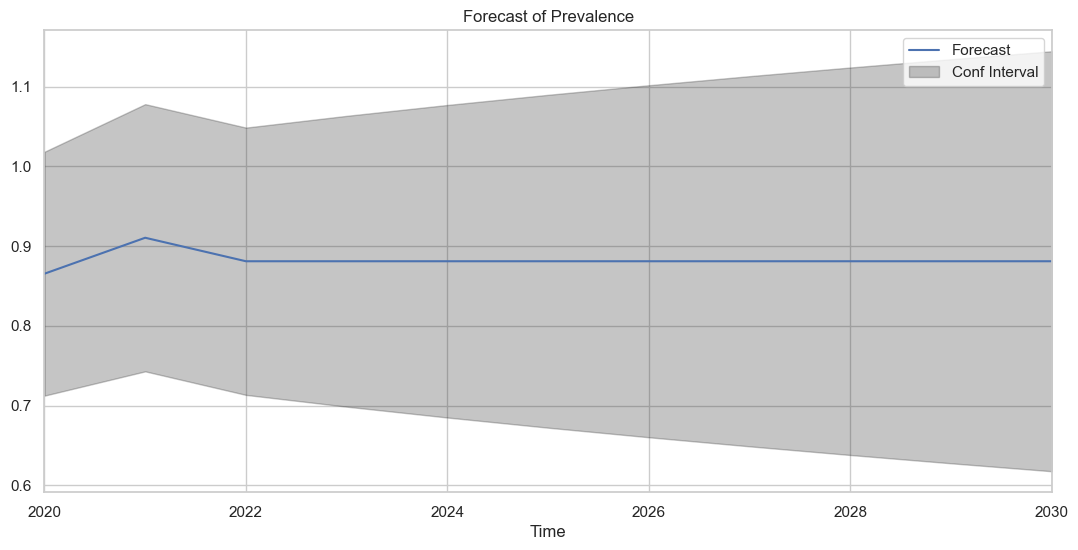

Total expected increase in prevalence in 1 year: 3.5640737422817907%
Total expected increase in prevalence in 3 years: 12.61142806254628%
Total expected increase in prevalence in 5 year: 44.625372334455136%
Total expected increase in prevalence in 7 year: 157.9062930948266%
Total expected increase in prevalence in 9 year: 558.7493413404529%


In [42]:
explicit_prev=forecast_model(loudness_df,pdq=pdq,pdqs=pdqs)